# Magic: The Gathering card detection based on image

## Imports

In [142]:
# Import required packages
import cv2
import pytesseract
from langdetect import detect
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tanguy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Detect text

(0.0, 1.0, 0.0, 1.0)

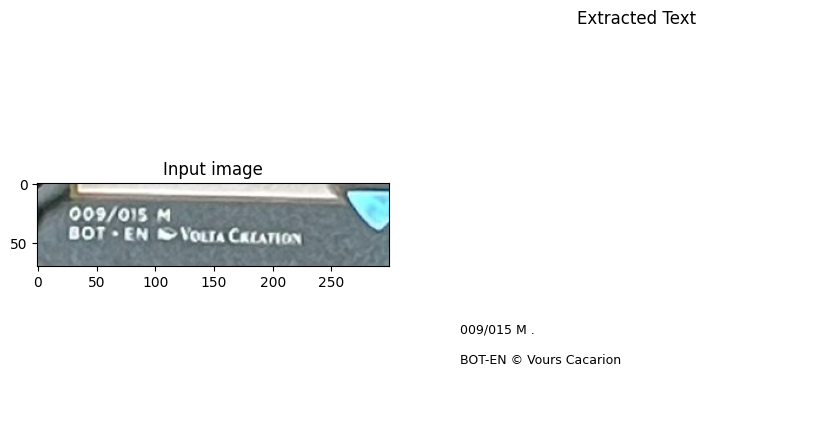

In [169]:
# Mention the installed location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

img_name = '4'

# Read image from which text needs to be extracted in either png or jpg format
img = cv2.imread('./cards/' + img_name + '.jpg')
if img is None:
    img = cv2.imread('./cards/' + img_name + '.png')

# Take the 200 first rows of pixels
img = img[-150:-80, 100:400]

# Apply OCR on the image
text = pytesseract.image_to_string(img)

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img)
ax1.set_title("Input image")

# Print the text
ax2 = fig.add_subplot(1, 2, 2)
ax2.text(0, 0.1, text, fontsize=9, ha="left")
ax2.set_title("Extracted Text")
ax2.axis("off")

## Detect language

In [144]:
print(detect("This is an example of language detection in python library."))

en


## Find card

In [146]:
# Load the "cards.json" file into a pandas dataframe
with open('./data/cards.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data)

# Preprocess the text data
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = ' '.join([word for word in text.split() if word not in stop_words])
        if not text:
            return ''
        return text
    return ''   

df['name'] = df['name'].apply(preprocess_text)
df['oracle_text'] = df['oracle_text'].apply(preprocess_text)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the preprocessed text data
corpus = df['name'] + ' ' + df['oracle_text']
vectorizer.fit(corpus)

TfidfVectorizer()

In [150]:

# Define a function to find the closest match to the input text
def find_closest_match(input_text):
    input_text = preprocess_text(input_text)
    input_vector = vectorizer.transform([input_text])
    similarities = cosine_similarity(input_vector, vectorizer.transform(corpus))
    closest_match_index = similarities.argmax()
    closest_match_id = df.iloc[closest_match_index]['id']
    return closest_match_id

# Use the function to find the closest match to the input text and return the corresponding 'id'
input_text = text
print(input_text)
closest_match_id = find_closest_match(input_text)
print(closest_match_id)
print(df[df['id'] == closest_match_id]['name'].values[0])
print(df[df['id'] == closest_match_id]['oracle_text'].values[0])

Enchant artifact you control

At the beginning of your upkeep, create a
token that’s a copy of enchanted artifact.
Then if you control eight or more artifacts
with the same name as one another, you
win the game.

“Give me eight walkers, ['ll give you the city.”
—Dovin Baan

038/184 M Py ™ & © 2017 Wizards of the Coast
AER + EN % ADAM PAQUETTE

S iy

235dd8f1-215a-4b0a-9e94-0d0d5a3c730b
mechanized production
enchant artifact control beginning upkeep create token thats copy enchanted artifact control eight artifacts name one another win game
